# KNN Classifier

#### Using the same flowers dataset

IMPORTING LIBRARIES

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    ConfusionMatrixDisplay
from timeit import default_timer as timer
from tqdm import tqdm
from time import time   #for qn 1.4

PREPROCESSING IMGES, LOADING IN DATASET, EXTRACTING COLOR HISTOGRAM

In [2]:
LABELS = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

def preprocess_image(path_to_image, img_size=150):
    img = cv2.imread(path_to_image, cv2.IMREAD_COLOR)  # Read image in
    img = cv2.resize(img, (img_size, img_size))  # Resize image
    return np.array(img)
      
def load_dataset(base_path="C:\\Users\\belei\\Desktop\\SIM\\Big Data\\YEAR 2\\Y2 SEM 3\\218\\LAB\\flowers"):
    X = []
    Y = []
    for i in range(0, len(LABELS)):
        current_size = len(X)
        folder_path = base_path + os.sep + LABELS[i]
        print(f"Checking folder: '{folder_path}'")  #debugging step
        print(f"Exists? {os.path.exists(folder_path)}")  #debugging line, should print true
        for img in tqdm(os.listdir(base_path + os.sep + LABELS[i])):
            X.append(preprocess_image(base_path + os.sep + LABELS[i] + '/' + img))
            Y.append(LABELS[i])
        print(f'Loaded {len(X) - current_size} {LABELS[i]} images')
    return X, Y

def extract_color_histogram(dataset, hist_size=6): #default size 6 histogram
    col_hist = []
    for img in dataset:
        hist = cv2.calcHist([img], [0, 1, 2], None, (hist_size, hist_size, hist_size), [0, 256, 0, 256, 0, 256])
        col_hist.append(cv2.normalize(hist,  None, 0, 1, cv2.NORM_MINMAX).flatten())
    return np.array(col_hist)

DISPLAYING RANDOM SAMPLES

In [3]:
def display_random_samples(X, y, samples_per_class=3):
    plt.figure(figsize=(15, 10))
    plt.suptitle('Random Samples from each flower type', fontsize = 16)

    for i, label in enumerate(LABELS):
        indices = [idx for idx, class_label in enumerate(y) if class_label == label]
        sample_indices = np.random.choice(indices, samples_per_class, replace=False)
        
        for j, idx in enumerate(sample_indices):
            plt.subplot(len(LABELS), samples_per_class, i*samples_per_class + j + 1)
            plt.imshow(cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB))
            plt.title(f'{label}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

DISPLAYING COLOR HISTOGRAM

In [4]:
def display_color_histograms(X, y, samples=3):

    sample_indices = np.random.choice(len(X), samples, replace=False)

    for idx in sample_indices:
        img = X[idx]
        label = y[idx]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f'Color distribution for {label}', fontsize=16)

        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2rGB))
        ax1.set_title('Original Image')
        ax1.axis('off')

        colors = ('b', 'g', 'r')
        for i, color in enumerate(colors):
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            ax2.plot(hist, color=color, label=f'{color.upper()} Channel')

            ax2.set_title('Color Histogram')
            ax2.set_xlabel('Pixel Value')
            ax2.set_ylabel('Frequency')
            ax2.legend()
            plt.tight_layout()
            plt.show()

HISTOGRAM EXAMPLE DISPLAY FUNCTION

In [5]:
def display_histogram_example(X, y, sample_index=0, hist_size=20):

    img = X[sample_index]
    label = y[sample_index]

    hist = cv2.calcHist([img], [0, 1, 2], None, (hist_size, hist_size, hist_size), [0, 256, 0, 256, 0, 256])
    normalised_hist = cv2.normalise(hist, None, 0, 1, cv2.NORM_MINMAX).flatten()

    plt.figure(figsize=(15,5))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(f'Color Histogram Analysis for {label}', fontsize=16)

    ax1.imshow(cv2.cvtColor(img, cv2.Color_BGR2RGB))
    ax1.set_title('Original Image')
    ax1.axis('off')

    non_zero_bins = normalised_hist[normalised_hist > 0]
    ax2.bar(range(len(non_zero_bins)), non_zero_bins)
    ax2.set_title(f'Non-zero bins in flattened histogram\nTotal bins: {len(normalised_hist)}, Non-zero bins: {len(non_zero_bins)}')
    ax2.setxlabel('Bin Index')
    ax2.setylabel('Normalised Count')

    plt.tight_layout()
    plt.show()

    print(f"\nHistogram shape: {hist.shape}")
    print(f"Flattened histogram shape: {normalised_hist.shape}")
    print("\nSample of non-zero bin values: ")
    for i, val in enumerate(non_zero_bins[:10]):
        print(f"bin {i}: {val: .4f}")

ANALYSE CORRECTLY AND INCORRECTLY CLASSIFIED IMAGES

In [6]:
def analyse_classifications(X_train, y_train, X_test, y_test, k = 5, hist_size=6):

    #Assingning knn to the k value of 5
    knn = KNeighborsClassifier(n_neighbors=k)

    X_train_hist = extract_color_histogram(X_train, hist_size)
    X_test_hist = extract_color_histogram(X_test, hist_size)
    knn.fit(X_train_hist, y_train)      #Training the model

    y_pred = knn.predict(X_test_hist)   #Predicting labels

    incorrect = np.where(y_pred !=y_test)[0]    #incorrect indices
    correct = np.where(y_pred == y_test)[0]     #correct indices

    #show 5 incorrect/correct images
    num_correct = min(5, len(correct))
    num_incorrect = min(5, len(incorrect))

    plt.figure(figsize=(12, 6))

    #Display correctly classified images
    for i in range(num_correct):
        idx = correct[i]
        plt.subplot(2, 5, i + 1)        #First row for correct classifications
        plt.imshow(cv2.cvtColor(X_test[idx], cv2.COLOR_BGR2RGB), aspect='equal')  # 'equal' keeps proportions
        plt.title(f"Predicted: {y_pred[idx]}\nActual: {y_test[idx]}", fontsize=12, pad=5)
        plt.axis("off")

    #Display incorrectly classified images
    for i in range(num_incorrect):
        idx = incorrect[i]
        plt.subplot(2, 5, i + 6)        #Second row for incorrect classifications
        plt.imshow(cv2.cvtColor(X_test[idx], cv2.COLOR_BGR2RGB), aspect='equal')
        plt.title(f"Predicted: {y_pred[idx]}\nActual: {y_test[idx]}", fontsize=12, pad=5)
        plt.axis("off")
    
    #Setting main title
    plt.suptitle("5 Correctly and Incorrectly Classified Images")
    confusion_pairs = [(y_test[i], y_pred[i]) for i in incorrect]
    common_confusions = {}

    for true, pred in confusion_pairs:
        pair = (true, pred)
        common_confusions[pair] = common_confusions.get(pair, 0) + 1

    sorted_confusions = sorted(common_confusions.items(), key=lambda x: x[1], reverse = True)

    for (true, pred), count in sorted_confusions[:5]:
        print(f"{true} mistaken for {pred}: {count} times")

STEP 1: LOADING IN DATASET >>>

Loading dataset...
Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\daisy'
Exists? True


100%|██████████| 764/764 [00:03<00:00, 241.94it/s]


Loaded 764 daisy images
Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\dandelion'
Exists? True


100%|██████████| 1052/1052 [00:04<00:00, 234.35it/s]


Loaded 1052 dandelion images
Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\rose'
Exists? True


100%|██████████| 784/784 [00:03<00:00, 221.84it/s]


Loaded 784 rose images
Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\sunflower'
Exists? True


100%|██████████| 733/733 [00:03<00:00, 224.07it/s]


Loaded 733 sunflower images
Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\tulip'
Exists? True


100%|██████████| 984/984 [00:04<00:00, 202.28it/s]


Loaded 984 tulip images
Dataset loaded: 4317 images

Displaying random samples from each flower type...


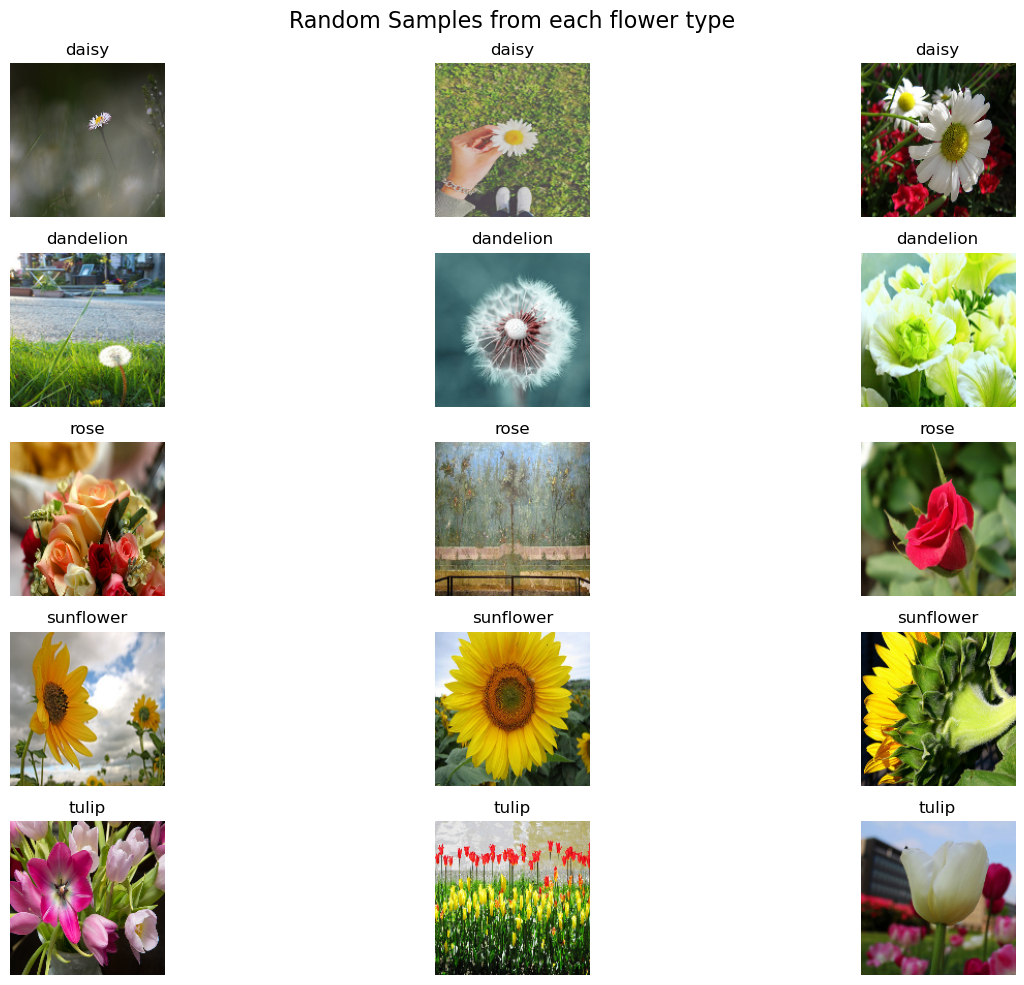

In [7]:

print("Loading dataset...")
X, y = load_dataset("C:\\Users\\belei\\Desktop\\SIM\\Big Data\\YEAR 2\\Y2 SEM 3\\218\\LAB\\flowers")
X = np.array(X)

print(f"Dataset loaded: {X.shape[0]} images")

print("\nDisplaying random samples from each flower type...")
display_random_samples(X, y)

STEP 2: SPLITTING DATASET INTO TRAIN, VALIDATION AND TEST

In [8]:

#splitting datset into training data, validation data and test data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nTrain set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")


Train set: 3021 images
Validation set: 648 images
Test set: 648 images


STEP 3: EXTRACTING COLOR HISTOGRAM FEATURES FROM DATASET

In [9]:
print ("Extracting color histogram features...")
X_train_hist = extract_color_histogram(X_train)
print(f"Shape of X_train_hist: {X_train_hist.shape}")
X_val_hist = extract_color_histogram(X_val)
X_test_hist = extract_color_histogram(X_test)

Extracting color histogram features...
Shape of X_train_hist: (3021, 216)


STEP 4: DETERMINING OPTIMAL K VALUES

In [10]:
k_values = [1, 3, 5, 7, 9, 11, 13, 15] #array of k values
val_accuracies = []

print("Finding optimal k value...")

#iterates through each k value in the array
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)   #considering nearest neighbours based on k values
    knn.fit(X_train_hist, y_train)              #trains the classifier using features and labels
    val_pred = knn.predict(X_val_hist)#uses trained classifier to predict labels for validation dataset 
    val_acc = accuracy_score(y_val, val_pred)   #calculates no of predictions that are correct
    val_accuracies.append(val_acc)      #saving accuracy for later comparison
    print(f"k={k}: validation accuracy = {val_acc: .4f}")

optimal_k = k_values[np.argmax(val_accuracies)] #assigning k value with most accuracies as optimal k
print(f"\nOptimal k value: {optimal_k}")

Finding optimal k value...
k=1: validation accuracy =  0.4043
k=3: validation accuracy =  0.4213
k=5: validation accuracy =  0.4167
k=7: validation accuracy =  0.4383
k=9: validation accuracy =  0.4429
k=11: validation accuracy =  0.4460
k=13: validation accuracy =  0.4491
k=15: validation accuracy =  0.4444

Optimal k value: 13


STEP 5: TRAINING KNN CLASSIFIER USING OPTIMAL K

In [11]:
print(f"\nTraining final model with k={optimal_k}...")
final_knn = KNeighborsClassifier(n_neighbors=optimal_k)
start_time = timer()
final_knn.fit(X_train_hist, y_train)
train_time = timer() - start_time
print(f"Training completed in {train_time: .2f} seconds")


Training final model with k=13...
Training completed in  0.00 seconds


STEP 6: EVALUATE KNN ON DATASET WITH DIFFERENT SIZES

In [12]:
print("\nEvaluating on test set with different histogram sizes...")

#array of smaller, middle and bigger hist sizes
hist_sizes = [3, 6, 12]

#for loop to test different sizes
for size in hist_sizes:
    print(f"Evaluating with hist_size = {size}...")

    X_train_hist = extract_color_histogram(X_train, hist_size=size)
    X_test_hist = extract_color_histogram(X_test, hist_size=size)

    start_time = timer()
    final_knn.fit(X_train_hist, y_train) #fitting in KNN model

    #evaluate on the test set
    y_pred = final_knn.predict(X_test_hist)
    accuracy = accuracy_score(y_test, y_pred)
    test_time = timer() - start_time

    print(f"\nAccuracy with hist_size={size}: {accuracy: .4f}")
    print(f"\nTest time: {test_time: .4f} seconds \n")



Evaluating on test set with different histogram sizes...
Evaluating with hist_size = 3...

Accuracy with hist_size=3:  0.4552

Test time:  0.0251 seconds 

Evaluating with hist_size = 6...

Accuracy with hist_size=6:  0.4552

Test time:  0.0421 seconds 

Evaluating with hist_size = 12...

Accuracy with hist_size=12:  0.3812

Test time:  0.1011 seconds 



STEP 7: CLASSIFICATION METRICS

In [13]:
accuracy = accuracy_score(y_test, y_pred)
#print('y_test: ', y_test)                      debug statement
#print('\ny_pred: ', y_pred)                    debug statement
precision = precision_score(y_test, y_pred, average='weighted')
#print('\nprinting precision: ', precision)     debug statement
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nClassification metrics: ")
print(f"Accuracy: {accuracy: .4f}")
print(f"Precision: {precision: .4f}")
print(f"Recall: {recall: .4f}")
print(f"F1-score: {f1: .4f}")
print(f"Average prediction time per image: {(test_time/len(X_test)):.4f} seconds")


Classification metrics: 
Accuracy:  0.3812
Precision:  0.3981
Recall:  0.3812
F1-score:  0.3817
Average prediction time per image: 0.0002 seconds


STEP 8: PLOTTING CONFUSION MATRIX

<Figure size 1500x1500 with 0 Axes>

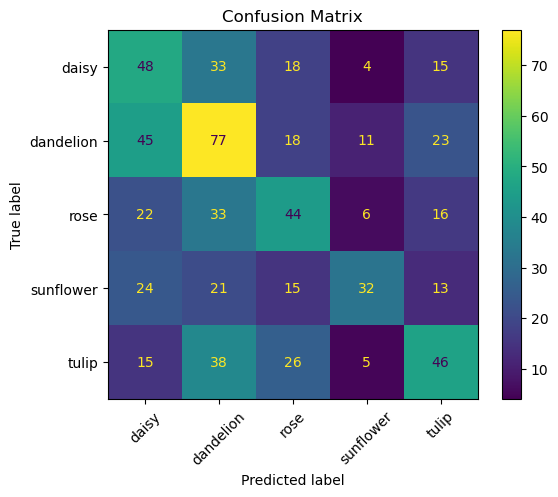

In [14]:

cm = confusion_matrix(y_test, y_pred, labels=LABELS)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
plt.figure(figsize=(15, 15))
disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

The pair of flowers that the classifier confuses the most is tulips and dandelions where the dandelions are often mistaken as tulips with a confusion matrix number of 38.

Average inference time of KNN classifier

In [ ]:
num_runs = 10           #no of times to run
inference_times = []

#for loop run for 10 times
for _ in range(num_runs):
    start_time = time()
    y_pred = final_knn.predict(X_test_hist)             #making the predictions
    end_time = time()

    total_time = end_time - start_time                  #to compute teh total inference time

    avg_time_per_sample = total_time / len(X_test_hist) #to find avg inference time per sample

    inference_times.append(avg_time_per_sample)         #to store results

average_inference_time = np.mean(inference_times)

print(f"Average inference time per sample over {num_runs} runs: {average_inference_time: .6f} seconds.")

Average inference time per sample over 10 runs:  0.000155 seconds.


STEP 9: SHOW 5 CORRECTLY/INCORRECTLY CLASSIFIED IMAGES


Analysing misclassified examples...
dandelion mistaken for daisy: 46 times
daisy mistaken for dandelion: 33 times
rose mistaken for dandelion: 29 times
tulip mistaken for dandelion: 29 times
sunflower mistaken for dandelion: 23 times


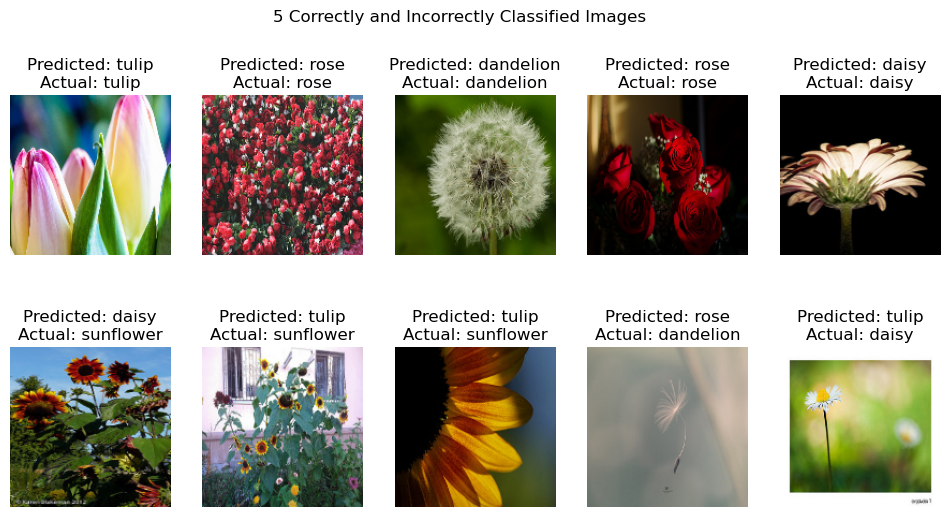

In [ ]:
print("\nAnalysing misclassified examples...")
analyse_classifications(X_train, y_train, X_test, y_test, k=optimal_k)